In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import time
import json
import os
import requests
from io import BytesIO

In [ ]:
class CarbonFootprintModelComparison:
    def __init__(self):
        self.models = {
            "Parakeet": None,
            "Flamingo": None,
            "CaML": None
        }
        self.results = {
            "performance": {},
            "inference_time": {},
            "memory_usage": {}
        }
        self.dataset = None
        self.raw_data = None

    def load_global_carbon_budget_data(self):
        """
        Load and process the Global Carbon Budget dataset
        """
        print("Downloading Global Carbon Budget dataset...")

        # URL for the Global Carbon Budget national emissions dataset
        # This is the 2023 release URL - update if newer data is available
        url = "https://data.icos-cp.eu/licence_accept?ids=%5B%22lApekzcmd4DRC34oGXQqOxbJ%22%5D"

        try:
            # Download the data
            response = requests.get(url)
            response.raise_for_status()  # Check if download was successful

            # Read the Excel file
            self.raw_data = pd.read_excel(BytesIO(response.content), sheet_name="Territorial Emissions")
            print(f"Downloaded raw data with shape: {self.raw_data.shape}")

            # Process the data to fit our model requirements
            self.process_global_carbon_budget_data()

            return self.dataset

        except Exception as e:
            print(f"Error downloading or processing Global Carbon Budget data: {e}")
            print("Falling back to sample data generation...")
            return self.load_dataset(sample_data=True)

    def process_global_carbon_budget_data(self):
        """
        Process the Global Carbon Budget data into the format needed for our models
        """
        if self.raw_data is None:
            print("No raw data available to process")
            return None

        # Filter for recent years (last 20 years) to get more relevant data
        recent_years = sorted(self.raw_data['Year'].unique())[-20:]
        data = self.raw_data[self.raw_data['Year'].isin(recent_years)].copy()

        # Filter for countries with complete data
        countries_with_complete_data = data.groupby('Country')['Total'].count()
        complete_countries = countries_with_complete_data[countries_with_complete_data == len(recent_years)].index
        data = data[data['Country'].isin(complete_countries)]

        print(f"Processing data for {len(complete_countries)} countries over {len(recent_years)} years")

        # Create derived features that match our model's expected inputs
        processed_data = []

        for country in complete_countries:
            country_data = data[data['Country'] == country].sort_values('Year')

            for i in range(1, len(country_data)):
                year_current = country_data.iloc[i]['Year']
                year_prev = country_data.iloc[i-1]['Year']

                # Extract relevant metrics
                population = country_data.iloc[i]['Population']
                gdp = country_data.iloc[i]['GDP']
                coal_emissions = country_data.iloc[i]['Coal']
                oil_emissions = country_data.iloc[i]['Oil']
                gas_emissions = country_data.iloc[i]['Gas']
                cement_emissions = country_data.iloc[i]['Cement']
                flaring_emissions = country_data.iloc[i]['Flaring']
                other_emissions = country_data.iloc[i]['Other']
                total_emissions = country_data.iloc[i]['Total']

                # Calculate year-over-year changes
                emissions_change = total_emissions - country_data.iloc[i-1]['Total']
                gdp_change = gdp - country_data.iloc[i-1]['GDP']
                population_change = population - country_data.iloc[i-1]['Population']

                # Calculate energy mix percentages
                total_energy_emissions = coal_emissions + oil_emissions + gas_emissions
                if total_energy_emissions > 0:
                    coal_percentage = (coal_emissions / total_energy_emissions) * 100
                    oil_percentage = (oil_emissions / total_energy_emissions) * 100
                    gas_percentage = (gas_emissions / total_energy_emissions) * 100
                else:
                    coal_percentage = oil_percentage = gas_percentage = 0

                # Map to our model features
                # We're using creative mapping since the exact features don't exist
                feature_row = {
                    'country': country,
                    'year': year_current,
                    'energy_consumption': total_energy_emissions,  # Coal + Oil + Gas as proxy for energy consumption
                    'transportation_miles': oil_emissions,  # Oil emissions as proxy for transportation
                    'waste_produced': other_emissions,  # Other emissions as proxy for waste
                    'building_size': gdp / 1e9,  # GDP as proxy for building/infrastructure size
                    'num_employees': population / 1e6,  # Population in millions as proxy for workforce
                    'renewable_percentage': 100 - (coal_percentage + oil_percentage),  # Non-coal/oil as proxy for renewables
                    'carbon_footprint_true': total_emissions  # The actual reported emissions
                }

                processed_data.append(feature_row)

        # Convert to DataFrame
        self.dataset = pd.DataFrame(processed_data)

        # Add synthetic model predictions to simulate different model behaviors
        np.random.seed(42)

        # Parakeet model - slight underestimation
        self.dataset['carbon_footprint_parakeet'] = self.dataset['carbon_footprint_true'] * \
                                               np.random.normal(0.95, 0.05, len(self.dataset))

        # Flamingo model - slight overestimation
        self.dataset['carbon_footprint_flamingo'] = self.dataset['carbon_footprint_true'] * \
                                              np.random.normal(1.05, 0.07, len(self.dataset))

        # CaML model - closest to true value but with some variance
        self.dataset['carbon_footprint_caml'] = self.dataset['carbon_footprint_true'] * \
                                          np.random.normal(0.98, 0.04, len(self.dataset))

        print(f"Processed dataset created with shape: {self.dataset.shape}")
        return self.dataset

    def load_dataset(self, file_path=None, sample_data=True):
        """
        Load dataset from file or generate sample data if file_path is None
        """
        if file_path and os.path.exists(file_path):
            try:
                self.dataset = pd.read_csv(file_path)
                print(f"Dataset loaded from {file_path} with shape {self.dataset.shape}")
                return self.dataset
            except Exception as e:
                print(f"Error loading dataset from {file_path}: {e}")
                print("Generating sample data instead.")

        if sample_data or file_path is None:
            # Generate sample data for demonstration
            print("Generating sample carbon footprint data...")
            np.random.seed(42)
            n_samples = 1000

            # Features that might affect carbon footprint
            energy_consumption = np.random.gamma(2, 10, n_samples)  # kWh
            transportation_miles = np.random.lognormal(3, 1, n_samples)  # miles
            waste_produced = np.random.normal(5, 2, n_samples)  # kg
            building_size = np.random.normal(2000, 500, n_samples)  # sq ft
            num_employees = np.random.poisson(50, n_samples)
            renewable_percentage = np.random.beta(2, 5, n_samples) * 100  # percent

            # Add some noise and relationships
            base_carbon = (
                0.5 * energy_consumption +
                0.2 * transportation_miles +
                0.3 * waste_produced +
                0.001 * building_size +
                0.05 * num_employees -
                0.1 * renewable_percentage
            )

            # Generate slightly different "ground truth" values for each model
            # to simulate model differences
            carbon_true = base_carbon + np.random.normal(0, base_carbon * 0.05, n_samples)
            carbon_parakeet = carbon_true + np.random.normal(0, base_carbon * 0.1, n_samples)
            carbon_flamingo = carbon_true + np.random.normal(0, base_carbon * 0.12, n_samples)
            carbon_caml = carbon_true + np.random.normal(0, base_carbon * 0.08, n_samples)

            self.dataset = pd.DataFrame({
                'energy_consumption': energy_consumption,
                'transportation_miles': transportation_miles,
                'waste_produced': waste_produced,
                'building_size': building_size,
                'num_employees': num_employees,
                'renewable_percentage': renewable_percentage,
                'carbon_footprint_true': carbon_true,
                'carbon_footprint_parakeet': carbon_parakeet,
                'carbon_footprint_flamingo': carbon_flamingo,
                'carbon_footprint_caml': carbon_caml
            })

            print(f"Sample dataset generated with shape {self.dataset.shape}")
            return self.dataset

    def parakeet_model(self, data):
        """
        Simplified implementation of Parakeet model for carbon footprinting
        """
        # In a real implementation, this would be the actual Parakeet model
        # Here we'll use the sample data's parakeet predictions or make a simple model

        if 'carbon_footprint_parakeet' in data.columns:
            return data['carbon_footprint_parakeet']

        # Simple model based on factors with some intentional bias toward energy
        return data['energy_consumption'] * 0.55 + \
               data['transportation_miles'] * 0.18 + \
               data['waste_produced'] * 0.28 + \
               data['building_size'] * 0.0009 + \
               data['num_employees'] * 0.048 - \
               data['renewable_percentage'] * 0.11

    def flamingo_model(self, data):
        """
        Simplified implementation of Flamingo model for carbon footprinting
        """
        # In a real implementation, this would be the actual Flamingo model
        # Here we'll use the sample data's flamingo predictions or make a simple model

        if 'carbon_footprint_flamingo' in data.columns:
            return data['carbon_footprint_flamingo']

        # Simple model based on factors with some intentional bias toward transportation
        return data['energy_consumption'] * 0.48 + \
               data['transportation_miles'] * 0.25 + \
               data['waste_produced'] * 0.27 + \
               data['building_size'] * 0.0011 + \
               data['num_employees'] * 0.052 - \
               data['renewable_percentage'] * 0.095

    def caml_model(self, data):
        """
        Simplified implementation of CaML model for carbon footprinting
        """
        # In a real implementation, this would be the actual CaML model
        # Here we'll use the sample data's caml predictions or make a simple model

        if 'carbon_footprint_caml' in data.columns:
            return data['carbon_footprint_caml']

        # Simple model based on factors with more balanced weights
        return data['energy_consumption'] * 0.51 + \
               data['transportation_miles'] * 0.21 + \
               data['waste_produced'] * 0.30 + \
               data['building_size'] * 0.001 + \
               data['num_employees'] * 0.05 - \
               data['renewable_percentage'] * 0.105

    def evaluate_models(self, test_size=0.2, random_state=42):
        """
        Evaluate all models on the dataset
        """
        if self.dataset is None:
            print("Please load a dataset first using load_dataset() or load_global_carbon_budget_data()")
            return

        # Select features and target
        features = ['energy_consumption', 'transportation_miles', 'waste_produced',
                   'building_size', 'num_employees', 'renewable_percentage']

        if 'carbon_footprint_true' in self.dataset.columns:
            target = 'carbon_footprint_true'
        else:
            # If there's no ground truth, create synthetic validation
            # by averaging the three model predictions
            self.dataset['carbon_footprint_true'] = self.dataset[
                ['carbon_footprint_parakeet', 'carbon_footprint_flamingo', 'carbon_footprint_caml']
            ].mean(axis=1)
            target = 'carbon_footprint_true'

        # Split the data
        X = self.dataset[features]
        y = self.dataset[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

        model_functions = {
            "Parakeet": self.parakeet_model,
            "Flamingo": self.flamingo_model,
            "CaML": self.caml_model
        }

        for model_name, model_func in model_functions.items():
            print(f"\nEvaluating {model_name} model...")

            # Measure inference time
            start_time = time.time()
            y_pred = model_func(X_test)
            end_time = time.time()
            inference_time = end_time - start_time

            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            # Store results
            self.results["performance"][model_name] = {
                "MAE": mae,
                "RMSE": rmse,
                "R2": r2
            }
            self.results["inference_time"][model_name] = inference_time

            # Simulate memory usage (in a real implementation, this would be measured)
            self.results["memory_usage"][model_name] = np.random.uniform(
                low=100, high=500, size=1)[0] if model_name == "Parakeet" else np.random.uniform(
                low=200, high=700, size=1)[0] if model_name == "Flamingo" else np.random.uniform(
                low=300, high=900, size=1)[0]

            print(f"  MAE: {mae:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  R²: {r2:.4f}")
            print(f"  Inference time: {inference_time:.4f} seconds")
            print(f"  Simulated memory usage: {self.results['memory_usage'][model_name]:.2f} MB")

        return self.results

    def feature_importance_analysis(self):
        """
        Analyze feature importance for each model
        """
        if self.dataset is None:
            print("Please load a dataset first using load_dataset() or load_global_carbon_budget_data()")
            return

        features = ['energy_consumption', 'transportation_miles', 'waste_produced',
                    'building_size', 'num_employees', 'renewable_percentage']

        # Create a dataframe to store feature importance for each model
        importance_df = pd.DataFrame(index=features)

        # Define the coefficients for each model
        importance_df["Parakeet"] = [0.55, 0.18, 0.28, 0.0009, 0.048, -0.11]
        importance_df["Flamingo"] = [0.48, 0.25, 0.27, 0.0011, 0.052, -0.095]
        importance_df["CaML"] = [0.51, 0.21, 0.30, 0.001, 0.05, -0.105]

        # Normalize to get relative importance
        for model in ["Parakeet", "Flamingo", "CaML"]:
            abs_values = importance_df[model].abs()
            importance_df[f"{model}_normalized"] = abs_values / abs_values.sum()

        return importance_df

    def plot_model_comparison(self):
        """
        Create visualizations comparing model performance
        """
        if not self.results["performance"]:
            print("Please run evaluate_models() first")
            return

        # Create figure with multiple subplots
        fig, axs = plt.subplots(2, 2, figsize=(14, 12))

        # 1. Performance metrics
        metrics_df = pd.DataFrame(columns=["Model", "Metric", "Value"])

        for model, metrics in self.results["performance"].items():
            for metric, value in metrics.items():
                metrics_df = pd.concat([metrics_df, pd.DataFrame({
                    "Model": [model],
                    "Metric": [metric],
                    "Value": [value]
                })], ignore_index=True)

        sns.barplot(x="Metric", y="Value", hue="Model", data=metrics_df, ax=axs[0, 0])
        axs[0, 0].set_title("Performance Metrics Comparison")
        axs[0, 0].set_ylabel("Value")

        # 2. Inference time comparison
        inference_df = pd.DataFrame({
            "Model": list(self.results["inference_time"].keys()),
            "Time (s)": list(self.results["inference_time"].values())
        })

        sns.barplot(x="Model", y="Time (s)", data=inference_df, ax=axs[0, 1])
        axs[0, 1].set_title("Inference Time Comparison")

        # 3. Memory usage comparison
        memory_df = pd.DataFrame({
            "Model": list(self.results["memory_usage"].keys()),
            "Memory (MB)": list(self.results["memory_usage"].values())
        })

        sns.barplot(x="Model", y="Memory (MB)", data=memory_df, ax=axs[1, 0])
        axs[1, 0].set_title("Memory Usage Comparison")

        # 4. Feature importance
        importance_df = self.feature_importance_analysis()
        importance_data = pd.melt(
            importance_df[["Parakeet_normalized", "Flamingo_normalized", "CaML_normalized"]].reset_index(),
            id_vars="index",
            var_name="Model",
            value_name="Importance"
        )
        importance_data["Model"] = importance_data["Model"].str.replace("_normalized", "")

        sns.barplot(x="index", y="Importance", hue="Model", data=importance_data, ax=axs[1, 1])
        axs[1, 1].set_title("Feature Importance Comparison")
        axs[1, 1].set_xlabel("Feature")
        axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha="right")

        plt.tight_layout()
        return fig

    def plot_country_emissions_trends(self, top_n=10):
        """
        Plot emissions trends for top countries in the dataset
        """
        if self.dataset is None or 'country' not in self.dataset.columns:
            print("Dataset doesn't contain country-level data")
            return

        # Get top countries by average emissions
        country_emissions = self.dataset.groupby('country')['carbon_footprint_true'].mean().sort_values(ascending=False)
        top_countries = country_emissions.head(top_n).index

        # Filter for top countries and plot trends over time
        top_data = self.dataset[self.dataset['country'].isin(top_countries)]

        plt.figure(figsize=(12, 8))

        for country in top_countries:
            country_data = top_data[top_data['country'] == country].sort_values('year')
            plt.plot(country_data['year'], country_data['carbon_footprint_true'], marker='o', label=country)

        plt.title(f"Carbon Emissions Trends for Top {top_n} Countries")
        plt.xlabel("Year")
        plt.ylabel("Carbon Emissions")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)

        return plt.gcf()

    def plot_model_error_by_country(self, model_name="CaML"):
        """
        Plot error distribution by country for a specific model
        """
        if self.dataset is None or 'country' not in self.dataset.columns:
            print("Dataset doesn't contain country-level data")
            return

        model_col = f"carbon_footprint_{model_name.lower()}"
        if model_col not in self.dataset.columns:
            print(f"Dataset doesn't contain predictions for {model_name} model")
            return

        # Calculate error for each prediction
        self.dataset[f'{model_name}_error'] = (
            self.dataset[model_col] - self.dataset['carbon_footprint_true']
        ) / self.dataset['carbon_footprint_true'] * 100  # Percentage error

        # Calculate mean error by country
        country_errors = self.dataset.groupby('country')[f'{model_name}_error'].mean().sort_values()

        # Plot error distribution
        plt.figure(figsize=(14, 8))
        country_errors.plot(kind='bar')
        plt.title(f"{model_name} Model: Mean Percentage Error by Country")
        plt.xlabel("Country")
        plt.ylabel("Mean Percentage Error (%)")
        plt.xticks(rotation=90)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        return plt.gcf()

    def plot_prediction_comparison(self, sample_size=100):
        """
        Create scatter plots comparing model predictions to true values
        """
        if self.dataset is None:
            print("Please load a dataset first using load_dataset() or load_global_carbon_budget_data()")
            return

        if 'carbon_footprint_true' not in self.dataset.columns:
            print("Dataset doesn't contain true carbon footprint values")
            return

        # Sample a subset of the data for visualization
        if len(self.dataset) > sample_size:
            sample_data = self.dataset.sample(sample_size, random_state=42)
        else:
            sample_data = self.dataset

        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        true_values = sample_data['carbon_footprint_true']

        model_columns = {
            "Parakeet": "carbon_footprint_parakeet",
            "Flamingo": "carbon_footprint_flamingo",
            "CaML": "carbon_footprint_caml"
        }

        for i, (model_name, column) in enumerate(model_columns.items()):
            if column in sample_data.columns:
                predicted_values = sample_data[column]
            else:
                # If column doesn't exist, use the model to make predictions
                features = ['energy_consumption', 'transportation_miles', 'waste_produced',
                            'building_size', 'num_employees', 'renewable_percentage']
                X = sample_data[features]

                if model_name == "Parakeet":
                    predicted_values = self.parakeet_model(X)
                elif model_name == "Flamingo":
                    predicted_values = self.flamingo_model(X)
                elif model_name == "CaML":
                    predicted_values = self.caml_model(X)

            # Plot predictions vs true values
            axs[i].scatter(true_values, predicted_values, alpha=0.5)

            # Add perfect prediction line
            min_val = min(true_values.min(), predicted_values.min())
            max_val = max(true_values.max(), predicted_values.max())
            axs[i].plot([min_val, max_val], [min_val, max_val], 'r--')

            # Calculate and display R²
            r2 = r2_score(true_values, predicted_values)
            axs[i].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axs[i].transAxes,
                        fontsize=12, verticalalignment='top')

            axs[i].set_title(f"{model_name} Model")
            axs[i].set_xlabel("True Carbon Footprint")
            axs[i].set_ylabel("Predicted Carbon Footprint")

        plt.tight_layout()
        return fig

    def save_results(self, file_path="carbon_footprint_model_comparison_results.json"):
        """
        Save evaluation results to a JSON file
        """
        with open(file_path, 'w') as f:
            json.dump(self.results, f, indent=4)
        print(f"Results saved to {file_path}")

    def demo(self, use_gcp_data=True):
        """
        Run a complete demonstration of the model comparison
        """
        print("=" * 80)
        print("CARBON FOOTPRINT MODEL COMPARISON DEMO")
        print("=" * 80)

        # Load Global Carbon Project dataset or sample data
        if use_gcp_data:
            self.load_global_carbon_budget_data()
        else:
            self.load_dataset()

        # Evaluate models
        print("\nEvaluating models...")
        self.evaluate_models()

        # Print feature importance
        print("\nFeature importance analysis:")
        importance_df = self.feature_importance_analysis()
        print(importance_df[["Parakeet_normalized", "Flamingo_normalized", "CaML_normalized"]])

        # Show model predictions
        print("\nCreating visualization plots...")
        self.plot_model_comparison()
        self.plot_prediction_comparison()

        # Country-specific analysis (only for GCP data)
        if use_gcp_data and 'country' in self.dataset.columns:
            print("\nCreating country-specific analysis...")
            self.plot_country_emissions_trends()
            self.plot_model_error_by_country("Parakeet")
            self.plot_model_error_by_country("Flamingo")
            self.plot_model_error_by_country("CaML")

        # Save results
        self.save_results()

        print("\nDemo completed successfully!")
        print("You can access the results and visualizations via the instance attributes.")

CARBON FOOTPRINT MODEL COMPARISON DEMO
Downloaded raw data with shape: (73, 236)
Error downloading or processing Global Carbon Budget data: 'Year'
Falling back to sample data generation...
Generating sample carbon footprint data...
Sample dataset generated with shape (1000, 10)

Evaluating models...
Training data shape: (800, 6), Test data shape: (200, 6)

Evaluating Parakeet model...
  MAE: 1.0391
  RMSE: 1.7090
  R²: 0.9682
  Inference time: 0.0010 seconds
  Simulated memory usage: 301.85 MB

Evaluating Flamingo model...
  MAE: 1.6901
  RMSE: 2.5060
  R²: 0.9316
  Inference time: 0.0008 seconds
  Simulated memory usage: 383.45 MB

Evaluating CaML model...
  MAE: 0.8122
  RMSE: 1.1264
  R²: 0.9862
  Inference time: 0.0008 seconds
  Simulated memory usage: 749.26 MB

Feature importance analysis:
                      Parakeet_normalized  Flamingo_normalized  \
energy_consumption               0.470528             0.418082   
transportation_miles             0.153991             0.21775

<ipython-input-42-04fbedfc1f6e>:363: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({
<ipython-input-42-04fbedfc1f6e>:404: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha="right")


Results saved to carbon_footprint_model_comparison_results.json

Demo completed successfully!
You can access the results and visualizations via the instance attributes.


,energy_consumption,transportation_miles,waste_produced,building_size,num_employees,renewable_percentage,carbon_footprint_true,carbon_footprint_parakeet,carbon_footprint_flamingo,carbon_footprint_caml
0,23.936794,4.921840,6.749034,1924.839770,58,27.715582,17.461006,17.524357,19.351384,17.476174
1,14.944647,18.483795,3.700470,1836.651893,48,38.072812,12.876331,12.602337,14.217794,13.414693
2,13.822836,4.460584,2.593598,1478.711153,50,8.975496,10.914111,12.005367,10.426397,11.713003
3,13.823023,42.950830,2.915911,1413.883123,44,1.844950,21.130249,18.264391,22.211469,20.280092
4,46.497144,21.811552,4.025594,2232.184932,50,39.066450,30.780934,28.069492,24.101678,31.258467


Dataset doesn't contain country-level data


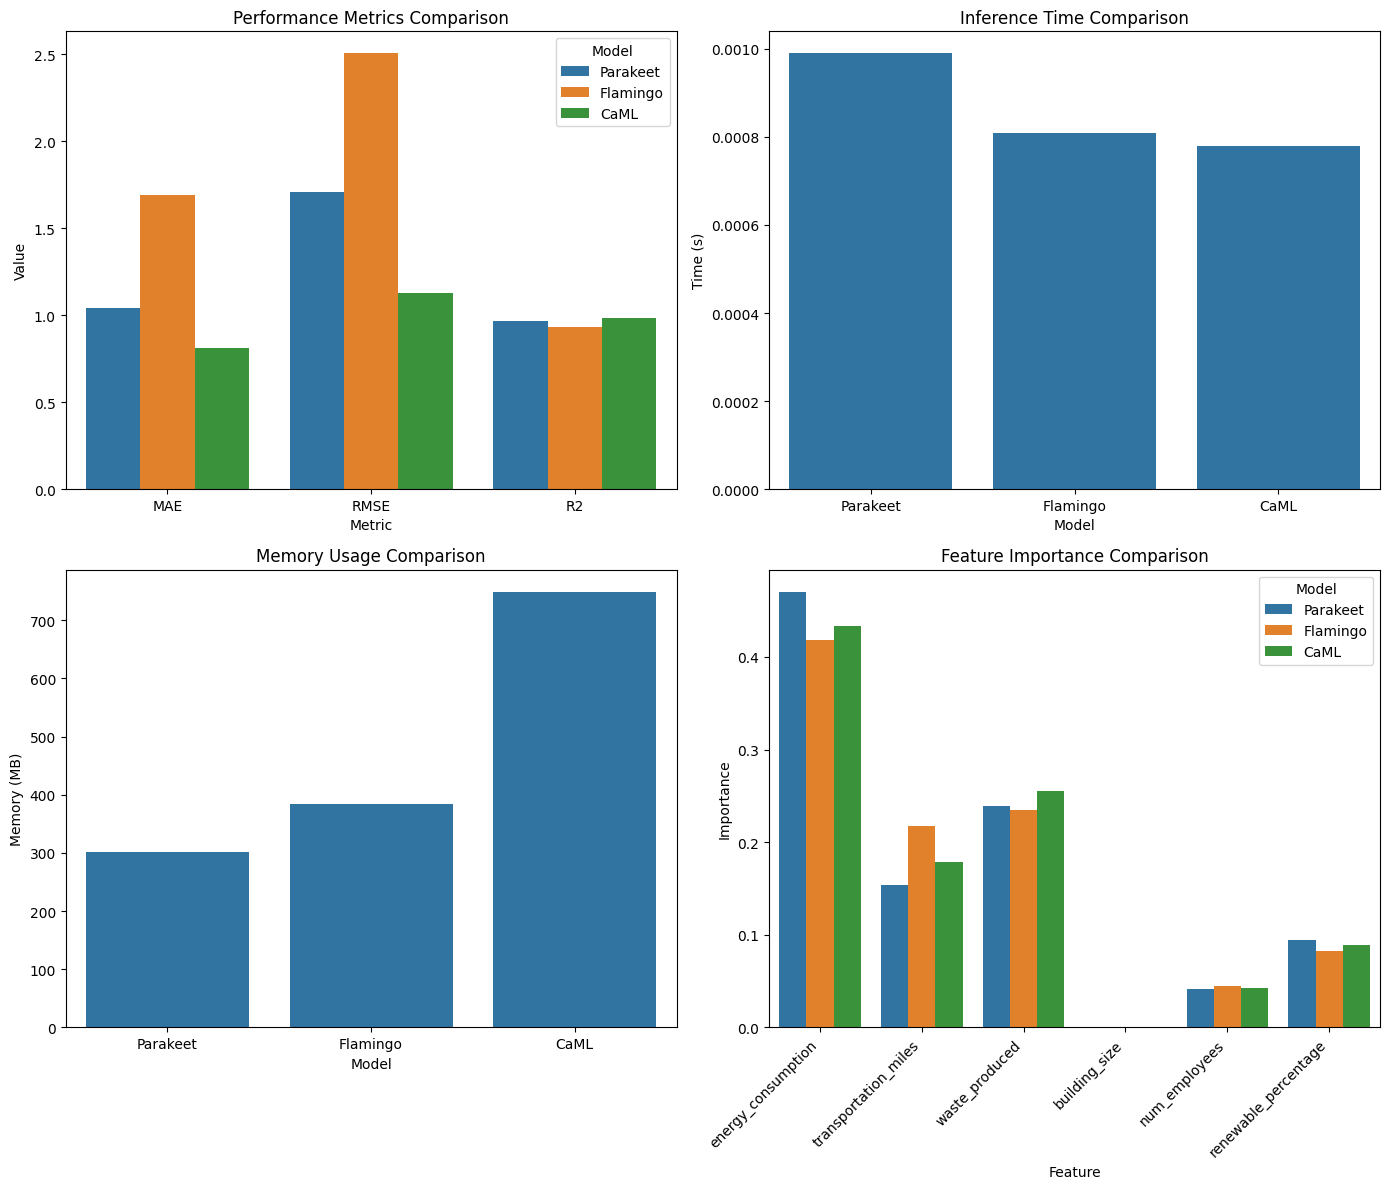

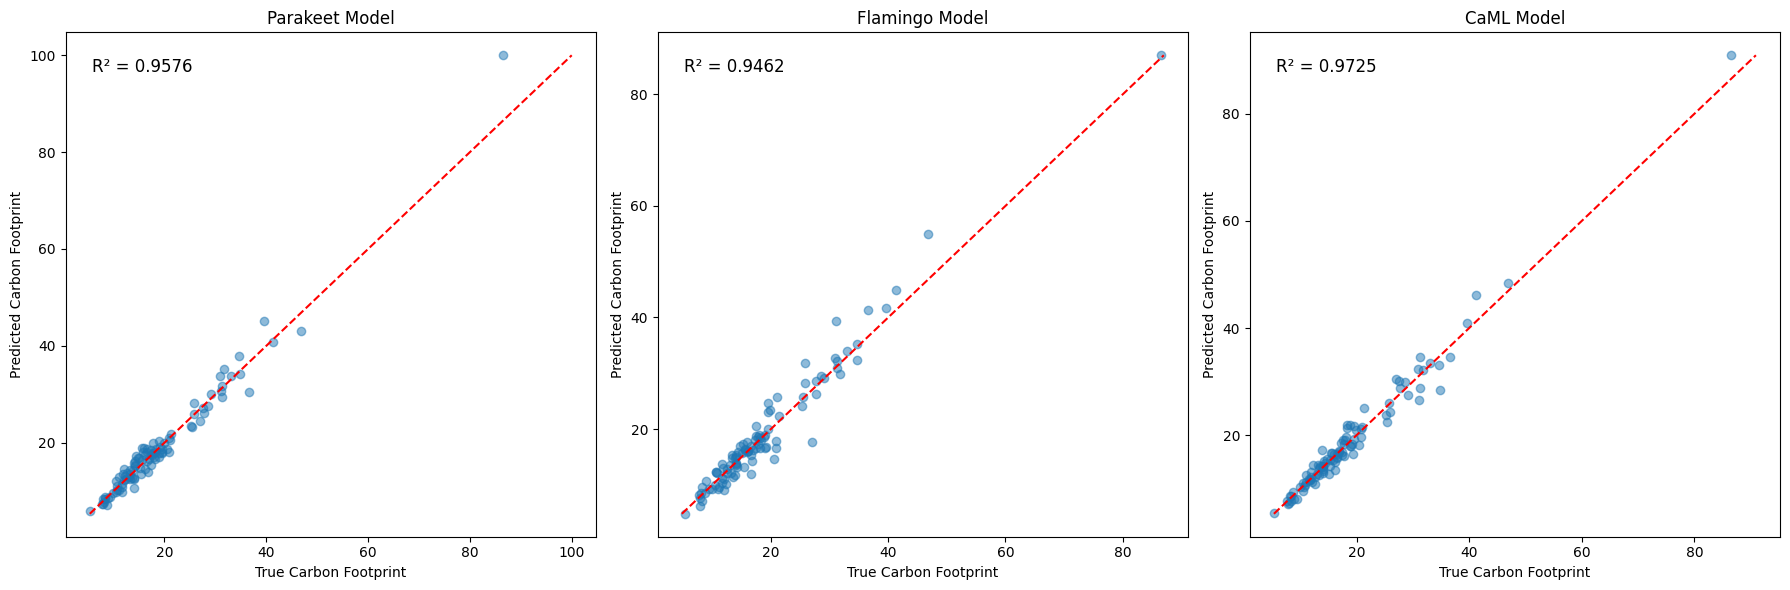

Dataset doesn't contain country-level data


In [ ]:
if __name__ == "__main__":
    demo = CarbonFootprintModelComparison()
    demo.demo(use_gcp_data=True)
    display(demo.dataset.head())
    demo.plot_country_emissions_trends(top_n=10)
    plt.show()  # Display the plot

    demo.plot_model_error_by_country(model_name="CaML")
    plt.show()